# Downloading Data from drive

In [ ]:
# Custom made Data
!gdown https://drive.google.com/uc?id=1wkvyKBdgQztOQosEYckO2nRQeFBi176S

Downloading...
From: https://drive.google.com/uc?id=1wkvyKBdgQztOQosEYckO2nRQeFBi176S
To: /content/NepaliText.csv
100% 946k/946k [00:00<00:00, 23.8MB/s]


In [ ]:
# Stop words
# credit -> Kushal Paudyal (https://github.com/sanjaalcorps/NepaliStopWords)
!gdown https://drive.google.com/uc?id=1rut_6tJVxvhW2sos425LGNbOb0RCNXmc

Downloading...
From: https://drive.google.com/uc?id=1rut_6tJVxvhW2sos425LGNbOb0RCNXmc
To: /content/NepaliStopWords.zip
100% 2.21k/2.21k [00:00<00:00, 5.86MB/s]


In [ ]:
!unzip /content/NepaliStopWords.zip

Archive:  /content/NepaliStopWords.zip
   creating: NepaliStopWords/
  inflating: NepaliStopWords/NepaliStopWords.txt  


In [1]:
# library for nepali text pre-processing
# credit -> prabash jha (https://github.com/prabhashj07/nepalikit)
!pip install nepalikit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.99
    Uninstalling sentencepiece-0.1.99:
      Successfully uninstalled sentencepiece-0.1.99


# Importing necessary libraries

In [12]:
import pandas as pd
import sys
import re
import sklearn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nepalikit.tokenization import Tokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nepalikit.preprocessing import TextProcessor
from nepalikit.manage_stopwords import load_stopwords, remove_stopwords_from_text

In [13]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Sklearn version:',sklearn.__version__)

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Pandas version: 2.1.4
Pytorch version: 2.4.0+cu121
Sklearn version: 1.3.2


# Data Pre processing

In [ ]:
processor = TextProcessor()

stopwords_path = '/content/NepaliStopWords'
stopwords = load_stopwords(stopwords_path)

def preprocess_text(text):
    # Removing html tags
    text = processor.remove_html_tags(text)
    # Removing special characters
    text = processor.remove_special_characters(text)
    # Replacing '\n' with emty space
    text = re.sub('\n', ' ', text)
    # Removing digits
    text = re.sub(r'[\d०१२३४५६७८९]', '', text)

    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

initial_dataset = pd.read_csv("/content/NepaliText.csv")

initial_dataset.rename(columns={'paras': 'data'}, inplace=True)

# Applying preprocessing function
initial_dataset['data'] = initial_dataset['data'].apply(preprocess_text)

# Removing duplicates and NAN values
initial_dataset.drop_duplicates(inplace=True)
initial_dataset.dropna(inplace=True)

# Encoding class labels
label_encoder = LabelEncoder()
initial_dataset['label'] = label_encoder.fit_transform(initial_dataset['label'])
num_classes = len(label_encoder.classes_)

# Data Preparation and Sanity checks

In [ ]:
train_dataset, validation_dataset = train_test_split(initial_dataset, test_size=0.1, random_state=42)

train_dataset.to_csv("./preprocessed_train.csv", index=False)
validation_dataset.to_csv("./preprocessed_val.csv", index=False)

In [ ]:
print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")

Length of training dataset: 357
Length of validation dataset: 40


In [ ]:
train_set = pd.read_csv("/content/preprocessed_train.csv")
train_set.head(5)

,data,label
0,त्रिभुवन विश्वविद्यालय विज्ञान प्रविधि अध्ययन ...,0
1,मानव शरीरको आङ्ग प्रत्यारोपण नियमित निषेध नियम...,2
2,त्रिभुवन विश्वविद्यालय विज्ञान प्रविधि अध्ययन ...,0
3,जिल्ला अदालत नियमावली मिति जिल्ला अदालत संशोधन...,2
4,प्रकाशन मिति स्टेशनरी मसलन्द सामग्री खरिदआपूर्...,3


In [ ]:
train_set['data'][0]

'त्रिभुवन विश्वविद्यालय विज्ञान प्रविधि अध्ययन संस्थान एकौ डीनको कार्यालय परीक्षा शाखा बल्खु सेमेष्टर परीक्षा प्रणाली वर्षे स्नातक तह विज्ञान विषयमा सालको नर्यां विदयार्थी भर्नाका प्रवेश परीक्षा सम्बन्धी संशोधित सुनना तरभुवन विश्वविद्यालय अन्तर्गतका आगिक न्याम्पस सम्वन्धन प्राप्त कलेजहरुमा सेमेष्टर परीक्षा परभाला शा पठन पाठन विज्ञान वर्षे स्नातक तह कम्प्यूटर विज्ञान सूचना प्रविधि विषयमा भर्ना इच्छुक विद्यार्थीहरुको निमित्त सालको निम्नानुसारको प्रवेश परीक्षा नया भर्ना सम्बन्धी संशौधित कार्यकम प्रकाशित गरिएको आवैदनको न्यूनतम यौग्यता क उच्च माध्यमिक माध्यमिक विद्यालयबाट विज्ञान विषय भौतिक शास्त्र गणित विषय पूगार िए परलेक विषपररमा भासत भ स व्रा ख गरेडिई प्रणाली हंकमा उच्च माध्यमिक माध्यमिक विद्यालयबाट यिज्ञान विषय ौलक गाल गगत निषय ससमा पूगप निद सीताण ब स हुनुपर्ने ग त्रिविवा यसवाट मान्यता प्राप्त शिक्षण संस्थाबाट प्रविणता प्रमाण पत्र तह सरहको ान विषयमा मौतिक शास्त्र गणित विषय कम्तिमा पूर्णाइ लिई कम्तिमा ॥ विज्ञान विषयमा भौतिक शास्त्र गणित विषय कम्तिमा पूर्णाइ लिई कम्तिमा ा फा ठा पाप डाी ट 

In [ ]:
encoded_label = train_set['label'][0]
class_name = label_encoder.inverse_transform([encoded_label])[0]

print(f"Encoded Label: {encoded_label}")
print(f"Class: {class_name}")

Encoded Label: 0
Class: Education


In [ ]:
val_set = pd.read_csv("/content/preprocessed_val.csv")
val_set.head(5)

,data,label
0,नेपाल सरकार जिल्ला प्रशासन कार्यालय ललितपुर सव...,3
1,नेपाल सरकार गृह मन्त्रालय जिल्ला प्रशासन कार्य...,1
2,नेपाल सरकार गृह मन्त्रालय जिल्ला प्रशासन कार्य...,1
3,त्रिभुवन विश्वविद्यालय विज्ञान प्रविधि अध्ययन ...,0
4,मिति लघुअनुसन्धान अनुदानको नतिजा प्रकाशन गरिएक...,0


In [ ]:
print("Missing values in training dataset:")
print(train_dataset.isnull().sum())

print("Missing values in validation dataset:")
print(validation_dataset.isnull().sum())

Missing values in training dataset:
data     0
label    0
dtype: int64
Missing values in validation dataset:
data     0
label    0
dtype: int64


In [ ]:
print("Number of duplicate rows in training dataset:")
print(train_dataset.duplicated().sum())

print("Number of duplicate rows in validation dataset:")
print(validation_dataset.duplicated().sum())

Number of duplicate rows in training dataset:
0
Number of duplicate rows in validation dataset:
0


In [ ]:
print("Class distribution in training dataset:")
print(train_dataset['label'].value_counts())

print("Class distribution in validation dataset:")
print(validation_dataset['label'].value_counts())

Class distribution in training dataset:
label
1    92
2    89
3    89
0    87
Name: count, dtype: int64
Class distribution in validation dataset:
label
0    13
2    10
3     9
1     8
Name: count, dtype: int64


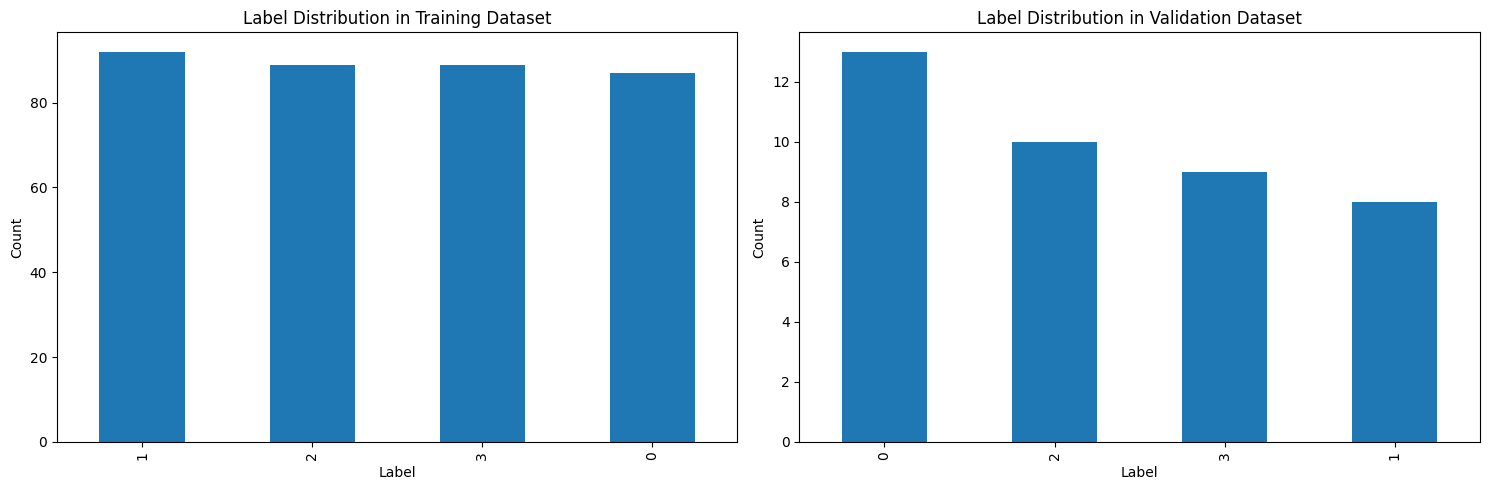

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_dataset['label'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Label Distribution in Training Dataset')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

validation_dataset['label'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Label Distribution in Validation Dataset')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

In [ ]:
train_dataset['text_length'] = train_dataset['data'].apply(len)
print("Text length statistics in training dataset:")
print(train_dataset['text_length'].describe())

Text length statistics in training dataset:
count     357.000000
mean      673.221289
std       388.399690
min       105.000000
25%       423.000000
50%       566.000000
75%       752.000000
max      2442.000000
Name: text_length, dtype: float64


There are 357 text samples in the training dataset.
The average length of the text samples is 673.
388 dispersion from mean.
The shortest text length in the train set is 105.
The longest text length in the train set is 2442.

In [ ]:
validation_dataset['text_length'] = validation_dataset['data'].apply(len)
print("Text length statistics in validation dataset:")
print(validation_dataset['text_length'].describe())

Text length statistics in validation dataset:
count      40.000000
mean      729.850000
std       457.427845
min       256.000000
25%       420.250000
50%       643.000000
75%       862.000000
max      2763.000000
Name: text_length, dtype: float64


# Tokenizer and vocabulary

In [ ]:
# Custom tokenizer using nepalikit
tokenizer = Tokenizer()

class CustomTokenizer:
    def __init__(self, tokenizer, vocab=None):
        self.tokenizer = tokenizer
        self.vocab = vocab if vocab else {}

    def build_vocab(self, texts):
        # 0 and 1 index will be used for reserved tokens
        index = 2
        self.vocab['<PAD>'] = 0
        self.vocab['<UNK>'] = 1
        for text in texts:
            tokens = self.tokenizer.tokenize(text, level = 'word')
            for token in tokens:
                if token not in self.vocab:
                    self.vocab[token] = index
                    index += 1

    def encode(self, text, max_length):
        tokens = self.tokenizer.tokenize(text)
        token_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        # Padding to ensure consistency
        token_ids = token_ids[:max_length] + [self.vocab['<PAD>']] * (max_length - len(token_ids))
        return token_ids

texts = initial_dataset['data'].tolist()

# Building vocabulary from the texts
custom_tokenizer = CustomTokenizer(tokenizer)
custom_tokenizer.build_vocab(texts)

In [ ]:
print(f"Vocabulary size: {len(custom_tokenizer.vocab)}")

Vocabulary size: 7191


In [ ]:
# Printing some sample tokens and corresponding indices from the vocabulary
print("Sample tokens from vocabulary:")
for token, idx in list(custom_tokenizer.vocab.items())[:10]:
    print(f"Token: {token}, Index: {idx}")

Sample tokens from vocabulary:
Token: <PAD>, Index: 0
Token: <UNK>, Index: 1
Token: स्नातक, Index: 2
Token: तह, Index: 3
Token: विज्ञान, Index: 4
Token: प्रविधि, Index: 5
Token: विषय, Index: 6
Token: चौथो्षाई, Index: 7
Token: अरदी, Index: 8
Token: शत्र, Index: 9


Verifying Tokenizer

In [ ]:
sample_text = texts[0]

# Encoding the sample text
encoded_text = custom_tokenizer.encode(sample_text, max_length=50)
print(f"Sample text: {sample_text}")
print(f"Encoded text: {encoded_text}")

# Decoding back
def decode(tokens, vocab):
    inv_vocab = {idx: token for token, idx in vocab.items()}
    return ' '.join([inv_vocab.get(idx, '<UNK>') for idx in tokens])

print(f"Decoded text: {decode(encoded_text, custom_tokenizer.vocab)}")

Sample text: स्नातक तह विज्ञान प्रविधि विषय चौथो्षाई अरदी शत्र त्रिभुवन विश्वविद्यालय विज्ञान प्रविधि अध्ययन संस्थान डीनको कार्यालय परीक्षा शाखा बल्खुवाट सेमेष्टर परीक्षा प्रणाली संचालन गरिने वर्षे स्नातक तह कम्प्यूटर विज्ञान सूचना प्रविधि विषय वर्ष आठौं शत्र समूहको नियमित शत्रको अगाडिका समूहको आशिक परीक्षार्थीहरुको मिति गते संचालन परीक्षाको परीक्षा केन्द्र तोकिएकोले सम्बन्धित सवैको जानकारीको सूचना प्रकाशित गरिएको क काठमाडौं बर्नहार्ट कलेज बाफल केन्द्र पाटन संयुक्त क्याम्पस प्राइम कलेज डीरवाक इन्स्टीच्यूट अफ टेक्नोलोजी एकेडेमिया इन्टरनेशनल कलेज हिमालय कलेज अफ इन्जिनियरिङ्ग नेपालय कलेज एशियन कलेज अफ हाईयर स्टडीजका सम्पूर्ण परीक्षार्थीहरु ख नेपालय कलेज कलंकी केन्द्र अमृत क्याम्पस एम्विशन कलेज नेशनल कलेज अफ कम्प्यूटर स्टडीज संगरमाथा कलेज अफ साइन्स एण्ड टेक्नोलोजी नागार्जुना कलेज अफ हइन्फरमेशन टेक्नोलोजी एशियन स्कूल अफ ग संमृद्धि कलेज लोकन्थली भक्तपुर केन्द्र भक्तपुर बहुमुखी क्याम्पस क्याथफोर्ड इन्टरनेशनल कलेज अफ इन्जिनियरिङ्ग एण्ड म्यानेजमेन्ट सेन्ट लरेन्स कलेज कलेज अफ एप्लाईड बिजनेस बेदा

In [ ]:
# Printing sample text and corresponding encoding with label

for _ in range(3):
    idx = random.randint(0, len(texts) - 1)
    encoded_label = initial_dataset['label'].iloc[idx]
    class_name = label_encoder.inverse_transform([encoded_label])[0]
    print(f"Sample text: {texts[idx]}")
    print(f"Encoded text: {custom_tokenizer.encode(texts[idx], max_length=50)}")
    print(f"Class: {class_name}")
    print("-" * 50)

Sample text: प्रशासन त्रिभुवन विश्वविद्यालय छलेखा भक्तपुर बहुमुखी क्याम्पस विविए ा दि एस्ती ति एस आई टि दुधपाटी भक्तपुर नेपाल पत्र संख्या चनं मिति सूचना विषय आवश्यक कागजपत्र अनिबार्य पेश वारे उपरोक्त सम्बन्धमा व्यवस्थापन संकाय डीन कार्यालयको निर्देशन बमोजिम सरकारी विद्यालयबाट उतिर्ण विद्यार्थीहरुले पाउनैत्रि वि कार्यकारी परिपदबाट पारित पूर्ण पालना बनौट गर्नका आवश्यक सम्पुण सरकारी विद्यालय सरकारी उच्च मावि अनिबार्य पेश गर्नुपर्नेछ क्याम्पस प्रशासन जवाफदेही सरकारी विद्यालयबाट उतिर्ण विद्यार्थीहरुले नियमानुसारको छात्रवृति कोटामा अध्ययन गर्नका लागी छुटै फाराम भरेर मर्ना आबेदन फाराम बुझाउनु पुनश्व छात्रवृत्ति प्राप्त सफल विद्यार्थीहरुले त्रि बि व्यवस्थापन संकाय डीन कार्यालयको परीक्षा नियन्त्रण महाशाखाबाट लिइने बोर्ड परीक्षा अनिवार्य नियमित उतिर्ण अनुतिर्ण अनिबार्य तिर्नु बोधार्थ लेखा शाखा भक्तपुर बहुस्खी क्यास्पस स्वतन्त्र किद्यार्थी यनियन मक्तपर बहुसूखी क्यास्पस सक पनुव
Encoded text: [1474, 10, 11, 2010, 82, 83, 51, 1473, 233, 1408, 2011, 1796, 1477, 931, 2012, 2013, 82, 238, 181, 182, 201

# Custom Dataset Class

In [ ]:
max_length = 256

class CustomTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.texts = dataframe['data'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Actual  text
        text = self.texts[idx]
        # Class labels for text
        label = self.labels[idx]
        # Vectorized text
        input_ids = torch.tensor(self.tokenizer.encode(text, self.max_length), dtype=torch.long)
        # tokens not equal to the padding token get a mask value of 1, and padding tokens get a mask value of 0.
        # This is beacuse we want to prevent padding tokens from contributing to training
        attention_mask = (input_ids != custom_tokenizer.vocab['<PAD>']).long()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Data loader for training and validation

In [ ]:
train_dataset = CustomTextDataset(pd.read_csv("./preprocessed_train.csv"), custom_tokenizer, max_length)
validation_dataset = CustomTextDataset(pd.read_csv("./preprocessed_val.csv"), custom_tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)

# Model Definition using LSTM

In [ ]:
vocab_size = len(custom_tokenizer.vocab)

class CustomLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(CustomLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled_output = torch.mean(lstm_out, dim=1)
        dropped_out = self.dropout(pooled_output)
        return self.fc(dropped_out)

# Training and Validation loop

In [ ]:
model = CustomLSTMClassifier(vocab_size=vocab_size, embedding_dim=50, hidden_dim=32, output_dim=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        epoch_acc += accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_acc += accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, validation_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch 1/20
Train Loss: 1.3890, Train Accuracy: 0.2109
Validation Loss: 1.3859, Validation Accuracy: 0.1719
Epoch 2/20
Train Loss: 1.3692, Train Accuracy: 0.3729
Validation Loss: 1.3808, Validation Accuracy: 0.2656
Epoch 3/20
Train Loss: 1.3649, Train Accuracy: 0.3260
Validation Loss: 1.3681, Validation Accuracy: 0.2969
Epoch 4/20
Train Loss: 1.3459, Train Accuracy: 0.3484
Validation Loss: 1.3505, Validation Accuracy: 0.2969
Epoch 5/20
Train Loss: 1.2980, Train Accuracy: 0.4391
Validation Loss: 1.2913, Validation Accuracy: 0.3750
Epoch 6/20
Train Loss: 1.2160, Train Accuracy: 0.4964
Validation Loss: 1.1611, Validation Accuracy: 0.5000
Epoch 7/20
Train Loss: 1.1405, Train Accuracy: 0.5526
Validation Loss: 1.0512, Validation Accuracy: 0.6406
Epoch 8/20
Train Loss: 1.0176, Train Accuracy: 0.6760
Validation Loss: 0.9257, Validation Accuracy: 0.7656
Epoch 9/20
Train Loss: 0.9007, Train Accuracy: 0.7182
Validation Loss: 0.8408, Validation Accuracy: 0.7656
Epoch 10/20
Train Loss: 0.6102, Train

# Sample predictions from Validation set

In [ ]:
def predict_with_texts(model, dataloader, dataset, device):
    model.eval()
    predictions = []
    true_labels = []
    texts = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            batch_texts = dataset.texts[i * dataloader.batch_size : min((i + 1) * dataloader.batch_size, len(dataset))]
            texts.extend(batch_texts)

    return true_labels, predictions, texts

true_labels, predictions, texts = predict_with_texts(model, validation_dataloader, validation_dataset, device)

for i in range(5):
    print(f"Text: {texts[i]}")
    print(f"True Class: {label_encoder.inverse_transform([true_labels[i]])[0]}")
    print(f"Predicted Class: {label_encoder.inverse_transform([predictions[i]])[0]}")
    print()

Text: नेपाल सरकार जिल्ला प्रशासन कार्यालय ललितपुर सवारी साधन खरिदसम्बन्धी सूचना प्रथम प्रकाशित मिति गते कार्यालयको चालु आव थान सवारी साधन खरिद गर्नुपर्न भएकोले सार्वजनिक खरिद ऐन संशोधन दफा उपदफा क सार्वजनिक खरिद नियमावली संशोधन नियम ख बमोजिम त्यस्ता सवारी साधन उत्पादक कम्पनी सोको आधिकारिक बिक्रताहरुको प्रतिस्पर्धा गराउनर क्याटलग सपिङ्ग विधिबाट खरिद गर्नपर्ने भएकोले सार्वजनिक खरिद नियमावली संशोधन नियम ख उपनियम प्रयोजनको देहाय बमोजिमको सवारी साधन बिक्री चाहने उत्पादक आधिकारिक बिक्रताले उत्पादनको आधिकारिक गुणस्तर मूल्य सुविधासहितको विवरण क्याटलग ब्रोसर फर्म भ्याट हाटा आर्थिक वर्ष आय कर चक्ता प्रमाणपत्र लगायतका कागजातहरुको प्रमाणित प्रतिलिपिहरु संलग्न राखी सूचना प्रकाशन मितिले दिनभित्र कार्यालयमा सिलबन्दी प्रस्ताव गर्नुहुन सम्बन्धित उत्पादक आधिकारिक बिक्रेताको जानकारीको सूचना प्रकाशन गरिएको सिनं ठेङ्कार्न समवारी साधनको सवारीको संक्षिप्त विवरण नाम ण ए ॥ पपपा तृप पपपा पच पव ंह्याध शप क्षाभा शक्षाप धा व फ लणिफधात री ता ा औैपता ां फ क्षात प तावप वावा ै फवावा वाटा संख्या कैफियत संक्षिप्त विवरणम